## Importing Libraries

In [6]:
import numpy as np

import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

## Reading Data

In [2]:
dataset_path = "titanic3.csv"
titanic_data = pd.read_csv(dataset_path)

titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)


titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

In [3]:
titanic_data

,survived,age,sibsp,parch,fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,29.000000,0,0,211.3375,1,0,0,0,1,1,0,0
1,1,0.920000,1,2,151.5500,0,1,0,0,1,1,0,0
2,0,2.000000,1,2,151.5500,1,0,0,0,1,1,0,0
3,0,30.000000,1,2,151.5500,0,1,0,0,1,1,0,0
4,0,25.000000,1,2,151.5500,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,14.500000,1,0,14.4542,1,0,1,0,0,0,0,1
1305,0,29.881138,1,0,14.4542,1,0,1,0,0,0,0,1
1306,0,26.500000,0,0,7.2250,0,1,1,0,0,0,0,1
1307,0,27.000000,0,0,7.2250,0,1,1,0,0,0,0,1


### Available Features

Age - Passenger Age

Sibsp - Number of Siblings / Spouses Aboard

Parch - Number of Parents / Children Aboard

Fare - Fare Amount Paid in British Pounds

Female - Binary variable indicating whether passenger is female

Male - Binary variable indicating whether passenger is male

EmbarkC - Binary variable indicating whether passenger embarked at Cherbourg

EmbarkQ - Binary variable indicating whether passenger embarked at Queenstown

EmbarkS - Binary variable indicating whether passenger embarked at Southampton

Class1 - Binary variable indicating whether passenger was in first class

Class2 - Binary variable indicating whether passenger was in second class

Class3 - Binary variable indicating whether passenger was in third class



### Converting Data to Numpy Array

In [4]:
# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

### Deep Learning Model

Architecture of Model is - 

1. First Layer - (12,8)
2. Hidden Layer - (8 Hidden Units)
3. Output Layer - 2 Unit


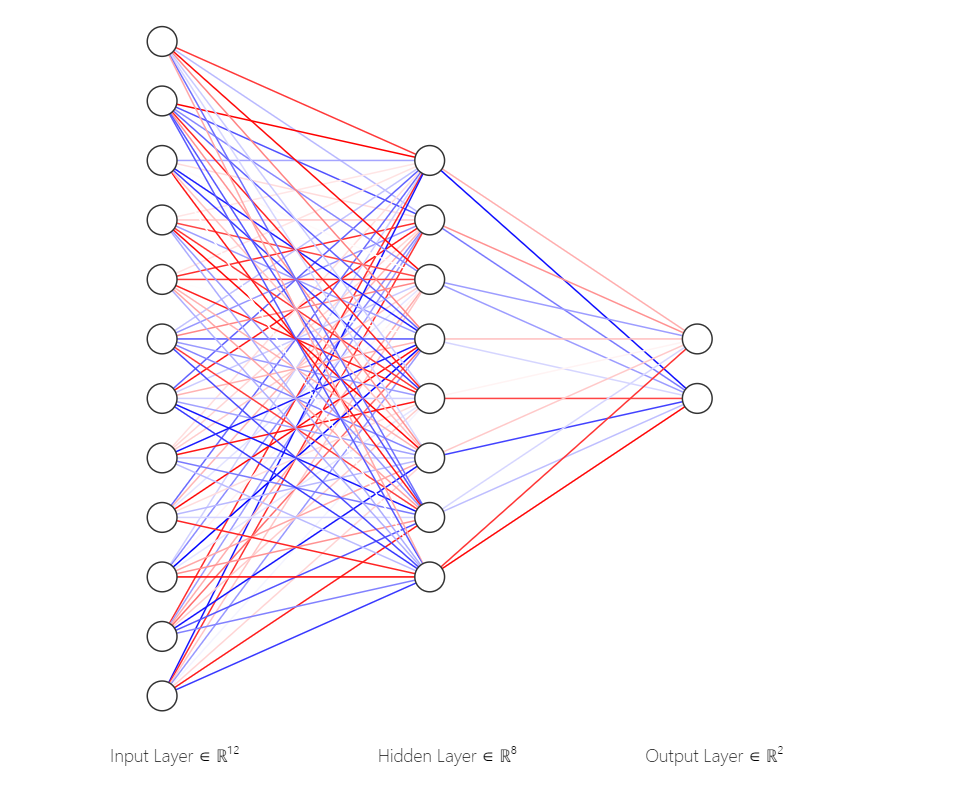

In [5]:
import torch
import torch.nn as nn
torch.manual_seed(1)  # Set seed for reproducibility.
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [5]:

net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('models/titanic_model.pt'))
    print("Model Loaded!")
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200

    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor= torch.from_numpy(train_labels)
    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        #Calculate the Gradient
        loss.backward()
        #Update the weights
        optimizer.step()
        
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'models/titanic_model.pt')

Epoch 1/200 => Loss: 0.70
Epoch 21/200 => Loss: 0.55
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.49
Epoch 101/200 => Loss: 0.48
Epoch 121/200 => Loss: 0.49
Epoch 141/200 => Loss: 0.48
Epoch 161/200 => Loss: 0.48
Epoch 181/200 => Loss: 0.47


### Evaluate Train & Test Scores

In [6]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8460698689956332


In [7]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.816793893129771


## First Question : What are the importances of each features? 

### Applying the Integrated Gradients

In [8]:
ig = IntegratedGradients(net)

#Making the Gradient computation efficient.
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

In [16]:
attr.shape

(393, 12)

Average Feature Importances
age :  -0.499
sibsp :  -0.067
parch :  -0.022
fare :  0.183
female :  0.122
male :  -0.486
embark_C :  0.145
embark_Q :  0.017
embark_S :  -0.088
class_1 :  0.113
class_2 :  0.032
class_3 :  -0.167


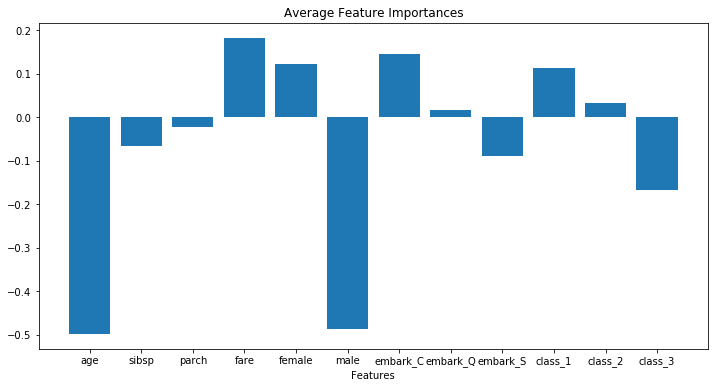

In [9]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(fedature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

### Insights

- Age and Being Male are important features which are negatively correlated with Survival. 
- Embarking And Number of Parents appears to be less important Features.


### Note - Average Attribution Over all the test set does not necessarily capture all information regarding feature importances. Distribution of attribution for each feature 

### Looking at the attribution of Single Example (Number of Siblings)

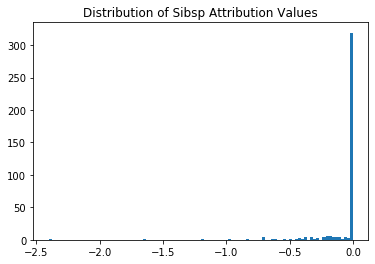

In [10]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");


# Second Question : Output of Neuron In a Particular Layer

### Layer Attributions

Simply the importance of Neuron in a given layer. 

In [11]:
cond = LayerConductance(net, net.sigmoid1)
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

Average Neuron Importances
0 :  0.003
1 :  -0.182
2 :  0.025
3 :  0.009
4 :  0.043
5 :  -0.076
6 :  0.011
7 :  0.000
8 :  -0.208
9 :  -0.000
10 :  -0.313
11 :  0.012


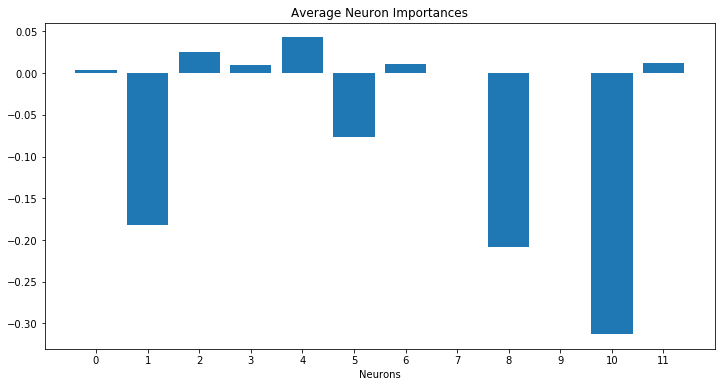

In [12]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

### Assignment - 

- Try to look at the Distribution of Neuron 7 and 9 ?

## Third Question : Which Input Feature is responsible for activating the  particular Neuron ? Is it single feature or multiple Feature ?

### Let's look which input feature is responsible for activating particular Neuron. 

Neuron total conductance divides the neuron's total conductance value into the contribution from each individual input feature.

In [13]:
neuron_cond = NeuronConductance(net, net.sigmoid1)
neuron_cond_vals_10 = neuron_cond.attribute(test_input_tensor, neuron_index=10, target=1)
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_index=0, target=1)

Average Feature Importances for Neuron 0
age :  0.003
sibsp :  0.000
parch :  0.000
fare :  0.001
female :  0.000
male :  -0.000
embark_C :  0.000
embark_Q :  0.000
embark_S :  0.000
class_1 :  0.000
class_2 :  0.000
class_3 :  0.000


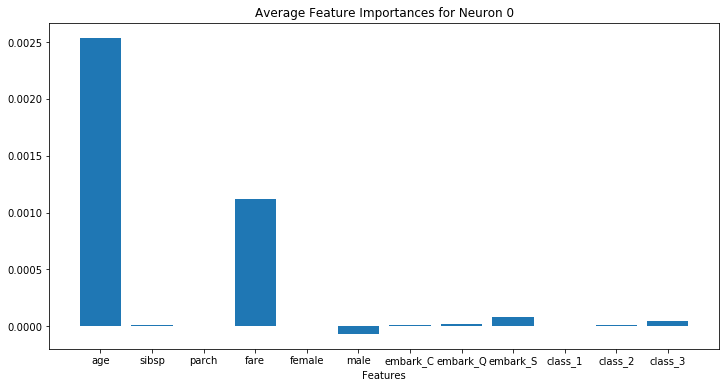

In [14]:
visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")

Average Feature Importances for Neuron 10
age :  -0.012
sibsp :  -0.002
parch :  -0.002
fare :  -0.013
female :  0.043
male :  -0.278
embark_C :  0.030
embark_Q :  -0.002
embark_S :  -0.059
class_1 :  0.072
class_2 :  0.030
class_3 :  -0.117


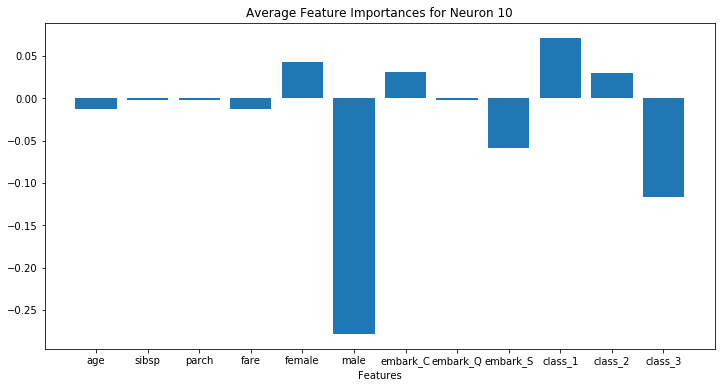

In [15]:

visualize_importances(feature_names, neuron_cond_vals_10.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 10")